#### Summary

Compute pairwise Wasserstein distances between individual, branching/spanning and clustered phenotypes to quantify robustness w.r.t:
  - sparse sampling
  - spatial scaling
  - time

In [1]:
using MAT
using NPZ
using PyPlot
using Eirene
using Random
using Statistics
using Distributions
using DelimitedFiles

Random.seed!(1234);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16629760212403013159\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16520477708306295187\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16629760212403013159\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### Helper methods

In [2]:
function get_cell_pos(filepath)
    
    posarray = readdlm(filepath, ',', '\n');
    posx = []
    posy = []
    
    for j in 1:size(posarray)[2]
        complex_num = parse(Complex{Float64}, posarray[j])
        push!(posx, real(complex_num));
        push!(posy, imag(complex_num));
    end

    final_positions = transpose(hcat(posx, posy));
    return final_positions
    
end;

function plot_cell_pos(cell_pos)
    
    figure(figsize=(4,4), dpi=300)
    scatter(cell_pos[1,:], cell_pos[2,:], s=8)
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
    ax = gca()
    ax.spines["top"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["right"].set_linewidth(2.5)
    
    show()
    
end;

### Without proliferation

In [3]:
parent_folder = "no_prolif_timelapse"

conditions = ["Clustered", "Spanning", "SpanningWClusters", "Individual"]

cond_pairs = [["Individual", "Spanning"], ["Individual", "SpanningWClusters"], ["Individual", "Clustered"],
              ["Spanning", "SpanningWClusters"], ["Spanning", "Clustered"],
              ["SpanningWClusters", "Clustered"]]

cond_pairs_sml = [["Individual", "Spanning"], ["Individual", "Clustered"], ["Spanning", "Clustered"]]


tpoints = 0:1000:200000
n_tpoints = length(tpoints)

removals = 0:1:198              
n_removals = length(removals)

scales = 0.2:0.05:5             
n_scales = length(scales)

repetitions = 1:10;             
n_reps = length(repetitions);

#### Random removals

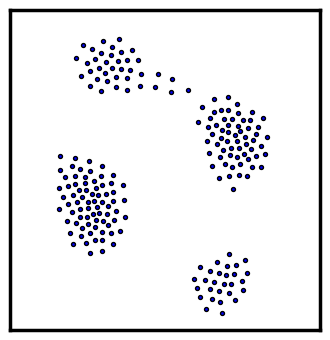

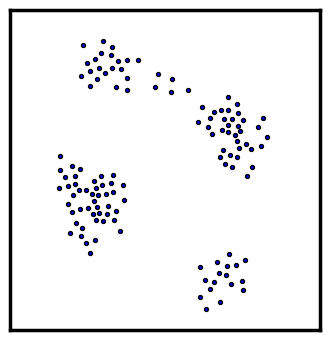

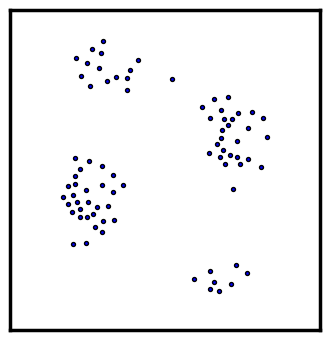

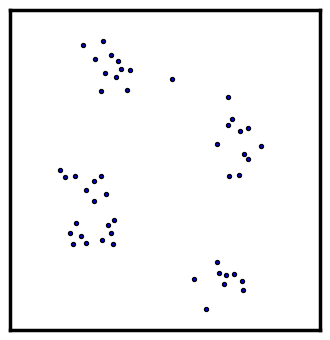

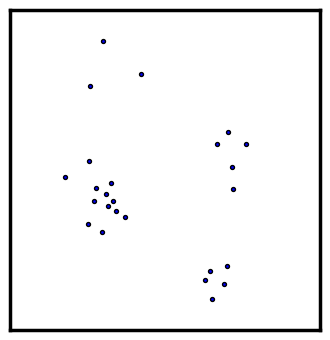

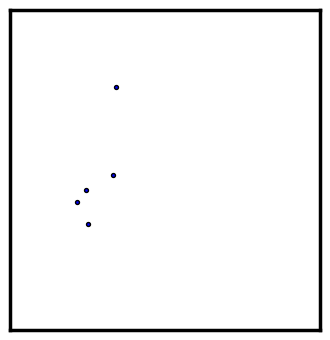

In [8]:
cond = "Clustered"
filepath = parent_folder * "/" * cond * "_1_rep/Pos_200000.dat"
cell_pos = get_cell_pos(filepath)

N_cells = size(cell_pos)[2]

for num_removals in [0, 75, 120, 150, 175, 195]
    
    rm_idx = randperm(N_cells)[1:N_cells-num_removals]
    
    cell_pos_sample = cell_pos[:,rm_idx]
    
    plot_cell_pos(cell_pos_sample)
    
end

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_removals)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for rem in removals
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_1 = get_cell_pos(filepath)
            N_cells_1 = size(final_positions_1)[2]
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_2 = get_cell_pos(filepath)
            N_cells_2 = size(final_positions_2)[2]
            
            if rem == 0
                
                pers_diag = eirene(final_positions_1, model="pc", maxdim=1);
                TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                pers_diag = eirene(final_positions_2, model="pc", maxdim=1);
                TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                q=2, p=2);
                
            else
                
                rm_idx_1 = randperm(N_cells_1)[1:N_cells_1-rem]
                rm_idx_2 = randperm(N_cells_2)[1:N_cells_2-rem]
                
                pers_diag = eirene(final_positions_1[:,rm_idx_1], model="pc", maxdim=1);
                TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                pers_diag = eirene(final_positions_2[:,rm_idx_2], model="pc", maxdim=1);
                TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                q=2, p=2);
                
            end
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("removal_wassdist_noprolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist))   
    
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);

#### Spatial scaling

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_scales)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for sc in scales
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_1 = get_cell_pos(filepath)
            N_cells_1 = size(final_positions_1)[2]
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_2 = get_cell_pos(filepath)
            N_cells_2 = size(final_positions_2)[2]
            
            if sc == 1
                
                pers_diag = eirene(final_positions_1, model="pc", maxdim=1);
                TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                pers_diag = eirene(final_positions_2, model="pc", maxdim=1);
                TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                q=2, p=2);
                
            else
                
                scaled_pos = final_positions_1 .* sc
                oob_mask = .|(abs.(scaled_pos[1,:]) .> 10, abs.(scaled_pos[2,:]) .> 10)

                xpos1 = [scaled_pos[1,i] for i in range(1, stop=N_cells_1) if oob_mask[i]==0];
                ypos1 = [scaled_pos[2,i] for i in range(1, stop=N_cells_1) if oob_mask[i]==0];
                
                scaled_pos_1 = transpose(hcat(xpos1, ypos1));
                                        
                N_oob_1 = sum(oob_mask)
                N_scaled_1 = size(scaled_pos_1)[2]        
                @assert N_cells_1 == N_oob_1 + N_scaled_1
                                        
                scaled_pos = final_positions_2 .* sc
                oob_mask = .|(abs.(scaled_pos[1,:]) .> 10, abs.(scaled_pos[2,:]) .> 10)

                xpos2 = [scaled_pos[1,i] for i in range(1, stop=N_cells_2) if oob_mask[i]==0];
                ypos2 = [scaled_pos[2,i] for i in range(1, stop=N_cells_2) if oob_mask[i]==0];
                scaled_pos_2 = transpose(hcat(xpos2, ypos2));
            
                N_oob_2 = sum(oob_mask)
                N_scaled_2 = size(scaled_pos_2)[2]        
                @assert N_cells_2 == N_oob_2 + N_scaled_2
                                                                
                if (N_scaled_1 <= 1 || N_scaled_2 <= 1)
                                                                    
                    wass_distance[rep, n_t] = 0.0;
            
                else
                                                                    
                    pers_diag = eirene(scaled_pos_1, model="pc", maxdim=1);
                    TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                    pers_diag = eirene(scaled_pos_2, model="pc", maxdim=1);
                    TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)                                            
                                                                    
                    wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                   q=2, p=2);
                                                                    
                end
                
            end
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("scale_wassdist_noprolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist)) 
    
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);

#### Timelapse

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_tpoints)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for tp in tpoints
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_" * lpad(tp, 6, "0") * ".dat"
            final_positions = get_cell_pos(filepath)
            pers_diag = eirene(final_positions, model="pc", maxdim=1);
            TDA_barcode_cond1 = barcode(pers_diag, dim=1)
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_" * lpad(tp, 6, "0") * ".dat"
            final_positions = get_cell_pos(filepath)
            pers_diag = eirene(final_positions, model="pc", maxdim=1);
            TDA_barcode_cond2 = barcode(pers_diag, dim=1)
            
            wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_cond1, TDA_barcode_cond2, q=2, p=2);
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("timelapse_wassdist_noprolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist))   
      
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);

### With proliferation enabled

In [12]:
parent_folder = "prolif_timelapse"

conditions = ["Clustered", "Spanning", "SpanningWClusters"]

cond_pairs_sml = [["Spanning", "SpanningWClusters"], ["SpanningWClusters", "Clustered"], ["Spanning", "Clustered"]]

tpoints = 0:1000:200000;
n_tpoints = length(tpoints);

removals = 0:1:180;
n_removals = length(removals);

scales = 0.2:0.05:10
n_scales = length(scales)

repetitions = 1:10;
n_reps = length(repetitions);

#### Random removals

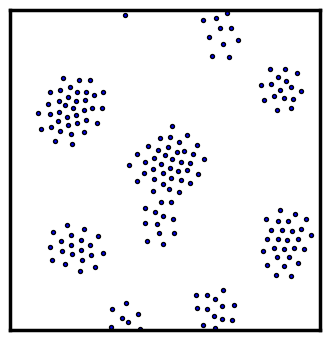

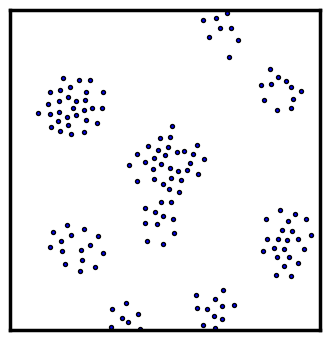

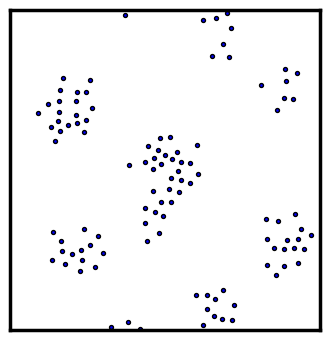

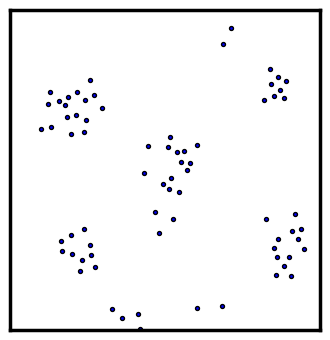

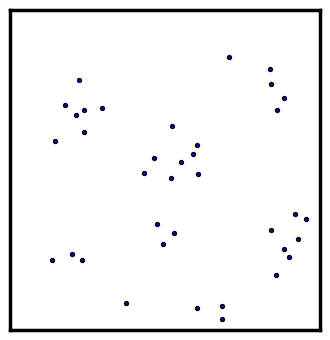

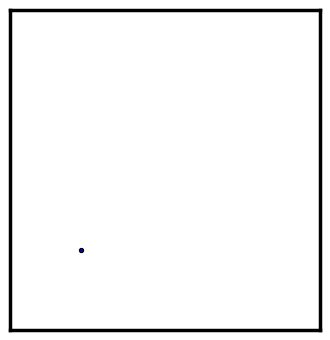

In [13]:
cond = "Clustered"
filepath = parent_folder * "/" * cond * "_1_rep/Pos_200000.dat"
cell_pos = get_cell_pos(filepath)

N_cells = size(cell_pos)[2]

for num_removals in 0:36:180
    
    rm_idx = randperm(N_cells)[1:N_cells-num_removals]
    
    cell_pos_sample = cell_pos[:,rm_idx]
    
    plot_cell_pos(cell_pos_sample)
    
end

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_removals)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for rem in removals
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_1 = get_cell_pos(filepath)
            N_cells_1 = size(final_positions_1)[2]
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_2 = get_cell_pos(filepath)
            N_cells_2 = size(final_positions_2)[2]
            
            if rem == 0
                
                pers_diag = eirene(final_positions_1, model="pc", maxdim=1);
                TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                pers_diag = eirene(final_positions_2, model="pc", maxdim=1);
                TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                q=2, p=2);
                
            else
                
                rm_idx_1 = randperm(N_cells_1)[1:N_cells_1-rem]
                rm_idx_2 = randperm(N_cells_2)[1:N_cells_2-rem]
                
                if (length(rm_idx_1) <= 1 || length(rm_idx_2) <= 1)
                    
                    wass_distance[rep, n_t] = 0
                    
                else
                
                    pers_diag = eirene(final_positions_1[:,rm_idx_1], model="pc", maxdim=1);
                    TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)

                    pers_diag = eirene(final_positions_2[:,rm_idx_2], model="pc", maxdim=1);
                    TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                    wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                   q=2, p=2);
                    
                end
                
            end
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("removal_wassdist_prolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist))   
    
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);

#### Spatial scaling

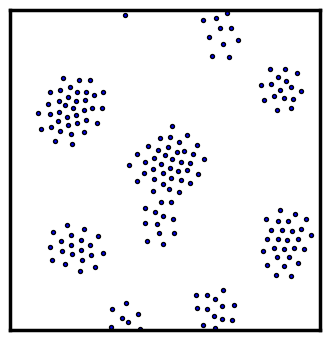

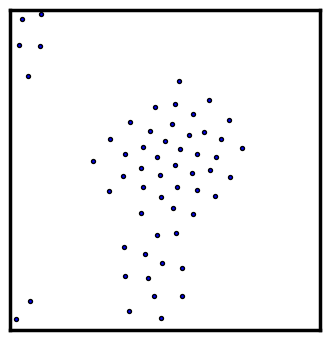

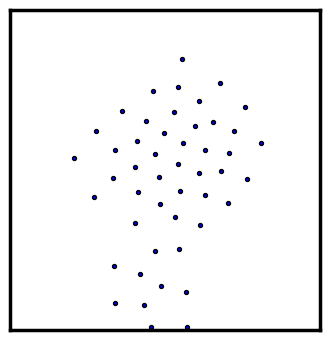

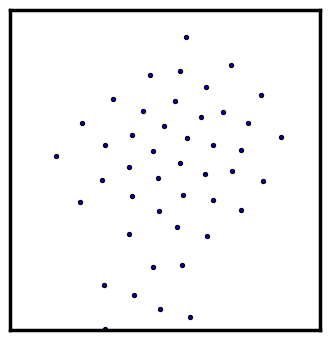

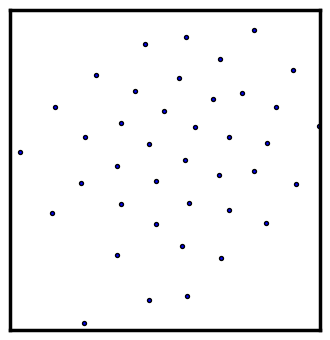

In [66]:
cond = "Clustered"
filepath = parent_folder * "/" * cond * "_1_rep/Pos_200000.dat"
cell_pos = get_cell_pos(filepath)

N_cells = size(cell_pos)[2]

for sc in [1,2,2.5,3,4]
    
    scaled_pos = cell_pos .* sc
    oob_mask = .|(abs.(scaled_pos[1,:]) .> 10, abs.(scaled_pos[2,:]) .> 10)

    xpos = [scaled_pos[1,i] for i in range(1, stop=N_cells) if oob_mask[i]==0];
    ypos = [scaled_pos[2,i] for i in range(1, stop=N_cells) if oob_mask[i]==0];
                
    cell_pos_sample = transpose(hcat(xpos, ypos));
    
    plot_cell_pos(cell_pos_sample)
    
end

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_scales)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for sc in scales
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_1 = get_cell_pos(filepath)
            N_cells_1 = size(final_positions_1)[2]
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_200000.dat"
            final_positions_2 = get_cell_pos(filepath)
            N_cells_2 = size(final_positions_2)[2]
            
            if sc == 1
                
                pers_diag = eirene(final_positions_1, model="pc", maxdim=1);
                TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                pers_diag = eirene(final_positions_2, model="pc", maxdim=1);
                TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)
                
                wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                q=2, p=2);
                
            else
                
                scaled_pos = final_positions_1 .* sc
                oob_mask = .|(abs.(scaled_pos[1,:]) .> 10, abs.(scaled_pos[2,:]) .> 10)

                xpos1 = [scaled_pos[1,i] for i in range(1, stop=N_cells_1) if oob_mask[i]==0];
                ypos1 = [scaled_pos[2,i] for i in range(1, stop=N_cells_1) if oob_mask[i]==0];
                
                scaled_pos_1 = transpose(hcat(xpos1, ypos1));
                                        
                N_oob_1 = sum(oob_mask)
                N_scaled_1 = size(scaled_pos_1)[2]        
                @assert N_cells_1 == N_oob_1 + N_scaled_1
                                        
                scaled_pos = final_positions_2 .* sc
                oob_mask = .|(abs.(scaled_pos[1,:]) .> 10, abs.(scaled_pos[2,:]) .> 10)

                xpos2 = [scaled_pos[1,i] for i in range(1, stop=N_cells_2) if oob_mask[i]==0];
                ypos2 = [scaled_pos[2,i] for i in range(1, stop=N_cells_2) if oob_mask[i]==0];
                scaled_pos_2 = transpose(hcat(xpos2, ypos2));
            
                N_oob_2 = sum(oob_mask)
                N_scaled_2 = size(scaled_pos_2)[2]        
                @assert N_cells_2 == N_oob_2 + N_scaled_2
                                                                
                if (N_scaled_1 <= 1 || N_scaled_2 <= 1)
                                                                    
                    wass_distance[rep, n_t] = 0.0;
            
                else
                                                                    
                    pers_diag = eirene(scaled_pos_1, model="pc", maxdim=1);
                    TDA_barcode_dim1_1 = barcode(pers_diag, dim=1)
                
                    pers_diag = eirene(scaled_pos_2, model="pc", maxdim=1);
                    TDA_barcode_dim1_2 = barcode(pers_diag, dim=1)                                            
                                                                    
                    wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_dim1_1, TDA_barcode_dim1_2, 
                                                                   q=2, p=2);
                                                                    
                end
                
            end
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("scale_wassdist_prolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist))   
    
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);

#### Timelapse

In [ ]:
originalSTDOUT = stdout
(outRead, outWrite) = redirect_stdout()

for cpair in cond_pairs_sml
    
    wass_distance = zeros(n_reps, n_tpoints)
    cond1 = cpair[1]
    cond2 = cpair[2]
    
    for rep in repetitions
        
        n_t = 1
        
        for tp in tpoints
            
            filepath = parent_folder * "/" * cond1 * "_" * string(rep) * "_rep/Pos_" * lpad(tp, 6, "0") * ".dat"
            final_positions = get_cell_pos(filepath)
            pers_diag = eirene(final_positions, model="pc", maxdim=1);
            TDA_barcode_cond1 = barcode(pers_diag, dim=1)
            
            filepath = parent_folder * "/" * cond2 * "_" * string(rep) * "_rep/Pos_" * lpad(tp, 6, "0") * ".dat"
            final_positions = get_cell_pos(filepath)
            pers_diag = eirene(final_positions, model="pc", maxdim=1);
            TDA_barcode_cond2 = barcode(pers_diag, dim=1)
            
            wass_distance[rep, n_t] = wasserstein_distance(TDA_barcode_cond1, TDA_barcode_cond2, q=2, p=2);
            
            n_t += 1
            
        end 
        
    end

    mean_wass_dist = vec(mean(wass_distance, dims=1))
    std_wass_dist = vec(std(wass_distance, dims=1))
    
    npzwrite("timelapse_wassdist_prolif_" * cond1 * "_" * cond2 * ".npz", Dict(
            "mean" => mean_wass_dist, "std" => std_wass_dist))   
    
end

close(outWrite);
close(outRead);
redirect_stdout(originalSTDOUT);